In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

In [2]:
# https://www.reneshbedre.com/blog/anova.html

# Anova Examples

## Example for one-way ANOVA analysis

In [4]:
df = pd.read_csv("anova02.csv", sep="\t")
df

,A,B,C,D
0,25,45,30,54
1,30,55,29,60
2,28,29,33,51
3,36,56,37,62
4,29,40,27,73


Here, there are four treatments (A, B, C, and D), which are groups for ANOVA analysis. Treatments are independent variable and termed as factor. As there are four types of treatments, treatment factor has four levels.

For this experimental design, there is only factor (treatments) or independent variable to evaluate, and therefore, one-way ANOVA method is suitable for analysis.

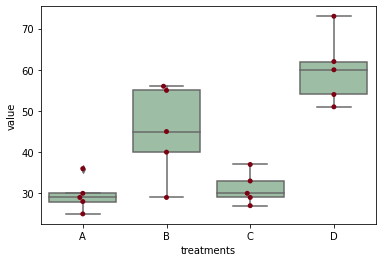

In [85]:
import pandas as pd
# load data file
df = pd.read_csv("anova02.csv", sep="\t")
# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
# replace column names
df_melt.columns = ['index', 'treatments', 'value']

# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
ax = sns.boxplot(x='treatments', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="treatments", y="value", data=df_melt, color='#7d0013')
plt.show()

In [24]:
df_melt.head()

,index,treatments,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29


In [6]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df['A'], df['B'], df['C'], df['D'])
print(fvalue, pvalue)
# 17.492810457516338 2.639241146210922e-05

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

17.492810457516338 2.639241146210922e-05


,sum_sq,df,F,PR(>F)
C(treatments),3010.95,3.0,17.49281,0.000026
Residual,918.00,16.0,NaN,NaN


In [7]:
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
res.anova_summary

# note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares (typ parameter) will produce similar results.

,df,sum_sq,mean_sq,F,PR(>F)
C(treatments),3.0,3010.95,1003.650,17.49281,0.000026
Residual,16.0,918.00,57.375,NaN,NaN


**Interpretation**

The p value obtained from ANOVA analysis is significant (p < 0.05), and therefore, we conclude that there are significant differences among treatments.

Note on F value: F value is inversely related to p value and higher F value (greater than F critical value) indicates a significant p value.

**Note:**<br/>
If you have unbalanced (unequal sample size for each group) data, you can perform similar steps as described for one-way ANOVA with balanced design (equal sample size for each group).

In [8]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='treatments', anova_model='value ~ C(treatments)')
res.tukey_summary

# Note: p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,A,B,15.4,1.692871,29.107129,4.546156,0.025070
1,A,C,1.6,-12.107129,15.307129,0.472328,0.900000
2,A,D,30.4,16.692871,44.107129,8.974231,0.001000
3,B,C,13.8,0.092871,27.507129,4.073828,0.048178
4,B,D,15.0,1.292871,28.707129,4.428074,0.029578
5,C,D,28.8,15.092871,42.507129,8.501903,0.001000


- Above results from Tukey’s HSD suggests that except A-C, 
- all other pairwise comparisons for treatments rejects null hypothesis (p < 0.05) and indicates statistical significant differences.

### Test ANOVA assumptions

-ANOVA assumptions can be checked using test statistics (e.g. Shapiro-Wilk, Bartlett’s, Levene’s test, Brown-Forsythe test) and the visual approaches such as residual plots (e.g. QQ-plots) and histograms.<br/>
-The visual approaches perform better than statistical tests. For example, the Shapiro-Wilk test has low power for small sample size data and deviates significantly from normality for large sample sizes (say n > 50). For large sample sizes, you should consider to use QQ-plot for normality assumption.

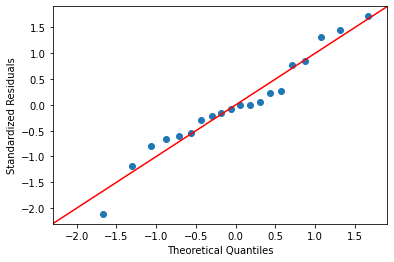

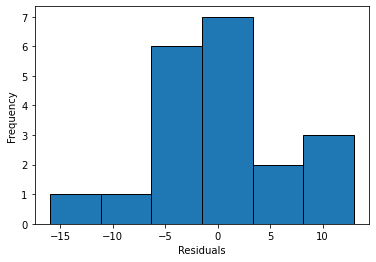

In [9]:
# QQ-plot
import statsmodels.api as sm
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

- As the standardized residuals lie around the 45-degree line, it suggests that the residuals are approximately normally distributed <br/>

- In the histogram, the distribution looks approximately normal and suggests that residuals are approximately normally distributed

- Shapiro-Wilk test can be used to check the normal distribution of residuals. Null hypothesis: data is drawn from normal distribution.

### Shapiro-Wilk test

In [10]:
import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.9685019850730896 0.7229772806167603


As the p value is non significant, we fail to reject null hypothesis and conclude that data is drawn from normal distribution

### Bartlett Test
As the data is drawn from normal distribution, use Bartlett’s test to check the Homogeneity of variances. Null hypothesis: samples from populations have equal variances.

In [11]:
import scipy.stats as stats
w, pvalue = stats.bartlett(df['A'], df['B'], df['C'], df['D'])
print(w, pvalue)

# if you have a stacked table, you can use bioinfokit v1.0.3 or later for the bartlett's test
from bioinfokit.analys import stat 
res = stat()
res.bartlett(df=df_melt, res_var='value', xfac_var='treatments')
res.bartlett_summary

5.687843565012841 0.1278253399753447


,Parameter,Value
0,Test statistics (T),5.6878
1,Degrees of freedom (Df),3.0000
2,p value,0.1278


As the p value (0.12) is non significant, we fail to reject null hypothesis and conclude that treatments have equal variances.

### Levene Test
Levene’s test can be used to check the Homogeneity of variances when the data is not drawn from normal distribution.

In [12]:
# if you have a stacked table, you can use bioinfokit v1.0.3 or later for the Levene's test
from bioinfokit.analys import stat 
res = stat()
res.levene(df=df_melt, res_var='value', xfac_var='treatments')
res.levene_summary

,Parameter,Value
0,Test statistics (W),1.9220
1,Degrees of freedom (Df),3.0000
2,p value,0.1667


## Two-Way Anova Analysis

For this experimental design, there are two factors to evaluate, and therefore, two-way ANOVA method is suitable for analysis. <br/>
Here, using two-way ANOVA, we can simultaneously evaluate how type of genotype and years affects the yields of plants. <br/>
If you apply one-way ANOVA here, you can able to evaluate only one factor at a time. <br/>

From two-way ANOVA, we can tests three hypotheses <br/>
1) effect of genotype on yield <br/>
2) effect of time (years) on yield, and <br/>
3) effect of genotype and time (years) interactions on yield

In [13]:
# load data file
d = pd.read_csv("anova_two_way.csv", sep="\t")
# reshape the d dataframe suitable for statsmodels package 
# you do not need to reshape if your data is already in stacked format. Compare d and d_melt tables for detail 
# understanding 
d_melt = pd.melt(d, id_vars=['Genotype'], value_vars=['1_year', '2_year', '3_year'])
# replace column names
d_melt.columns = ['Genotype', 'years', 'value']
d_melt.head()

,Genotype,years,value
0,A,1_year,1.53
1,A,1_year,1.83
2,A,1_year,1.38
3,B,1_year,3.60
4,B,1_year,2.94


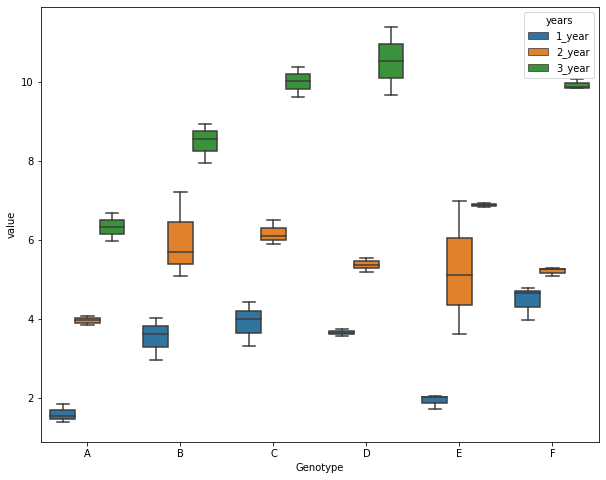

In [14]:
# generate a boxplot to see the data distribution by genotypes and years. Using boxplot, we can easily detect the 
# differences between different groups
plt.figure(figsize=(10,8))
sns.boxplot(x="Genotype", y="value", hue="years", data=d_melt) ;

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('value ~ C(Genotype) + C(years) + C(Genotype):C(years)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Genotype),58.551733,5.0,32.748581,1.931655e-12
C(years),278.925633,2.0,390.014868,4.006243e-25
C(Genotype):C(years),17.122967,10.0,4.788525,2.230094e-04
Residual,12.873000,36.0,NaN,NaN


In [16]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=d_melt, res_var='value', anova_model='value~C(Genotype)+C(years)+C(Genotype):C(years)')
res.anova_summary

#Note: If you have unbalanced (unequal sample size for each group) data,
#you can perform similar steps as described for two-way ANOVA with the balanced design but set `typ=3`. 
#Type 3 sums of squares (SS) does not assume equal sample sizes among the groups and is recommended for an unbalanced design for multifactorial ANOVA.

,df,sum_sq,mean_sq,F,PR(>F)
C(Genotype),5.0,58.551733,11.710347,32.748581,1.931655e-12
C(years),2.0,278.925633,139.462817,390.014868,4.006243e-25
C(Genotype):C(years),10.0,17.122967,1.712297,4.788525,2.230094e-04
Residual,36.0,12.873000,0.357583,NaN,NaN


**Interpretation**

The p value obtained from ANOVA analysis for genotype, years, and interaction are statistically significant (p<0.05).
1. We conclude that type of genotype significantly affects the yield outcome,
2. time (years) significantly affects the yield outcome, 
3. and interaction of both genotype and time (years) significantly affects the yield outcome.

As the interaction is significant, let’s visualize the interaction plot (also called profile plot) for interaction effects,

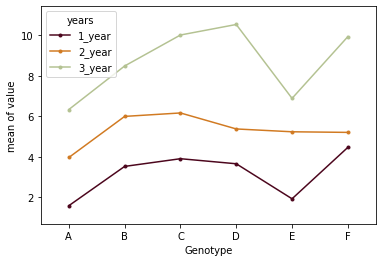

In [17]:
from statsmodels.graphics.factorplots import interaction_plot
fig = interaction_plot(x=d_melt['Genotype'], trace=d_melt['years'], response=d_melt['value'], 
    colors=['#4c061d','#d17a22', '#b4c292'])
plt.show()

-The interaction plot helps to visualize the means of the response of the two factors (Genotype and years) on one graph. Generally, the X-axis should have a factor with more levels.<br/>
-From the interaction plot, the interaction effect is significant between the Genotype and years because three lines are not parallel <br/>
(roughly parallel factor lines indicate no interaction - additive model). This interaction is also called ordinal interaction as the lines do not cross each other.<br/>
-For a more reliable conclusion of the interaction plot, it should be verified with the F test for interaction

### Multiple pairwise comparisons (Post-hoc test)

- Now, we know that genotype and time (years) differences are statistically significant, but ANOVA does not tell which genotype and time (years) are significantly different from each other.
- To know the pairs of significant different genotype and time (years), perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey’s HSD test.

### Tukey Test

In [18]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
# for main effect Genotype
res.tukey_hsd(df=d_melt, res_var='value', xfac_var='Genotype', anova_model='value~C(Genotype)+C(years)+C(Genotype):C(years)')
res.tukey_summary

# Note: p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,A,B,2.040000,1.191912,2.888088,10.234409,0.001000
1,A,C,2.733333,1.885245,3.581421,13.712771,0.001000
2,A,D,2.560000,1.711912,3.408088,12.843180,0.001000
3,A,E,0.720000,-0.128088,1.568088,3.612145,0.135306
4,A,F,2.573333,1.725245,3.421421,12.910072,0.001000
5,B,C,0.693333,-0.154755,1.541421,3.478361,0.163609
6,B,D,0.520000,-0.328088,1.368088,2.608771,0.453066
7,B,E,1.320000,0.471912,2.168088,6.622265,0.001000
8,B,F,0.533333,-0.314755,1.381421,2.675663,0.425189
9,C,D,0.173333,-0.674755,1.021421,0.869590,0.900000


In [19]:
# for main effect years
res.tukey_hsd(df=d_melt, res_var='value', xfac_var='years', anova_model='value ~ C(Genotype) + C(years) + C(Genotype):C(years)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,1_year,2_year,2.146667,1.659513,2.633821,15.230432,0.001
1,1_year,3_year,5.521667,5.034513,6.008821,39.175794,0.001
2,2_year,3_year,3.375000,2.887846,3.862154,23.945361,0.001


In [20]:
# for interaction effect between genotype and years
res.tukey_hsd(df=d_melt, res_var='value', xfac_var=['Genotype','years'], anova_model='value ~ C(Genotype) + C(years) + C(Genotype):C(years)')
res.tukey_summary.head()

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(A, 1_year)","(A, 2_year)",2.38,0.548861,4.211139,6.893646,0.002439
1,"(A, 1_year)","(A, 3_year)",4.75,2.918861,6.581139,13.758326,0.001000
2,"(A, 1_year)","(B, 1_year)",1.94,0.108861,3.771139,5.619190,0.028673
3,"(A, 1_year)","(B, 2_year)",4.41,2.578861,6.241139,12.773520,0.001000
4,"(A, 1_year)","(B, 3_year)",6.90,5.068861,8.731139,19.985779,0.001000


### Test Anonva assumptions

Similar to one-way ANOVA, you can use visual approaches, Bartlett’s or Levene’s, and Shapiro-Wilk test to validate the assumptions for homogeneity of variances and normal distribution of residuals.

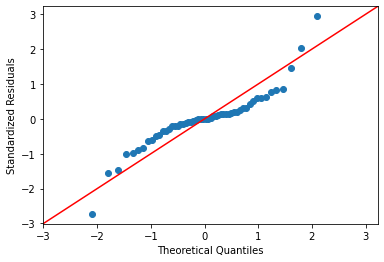

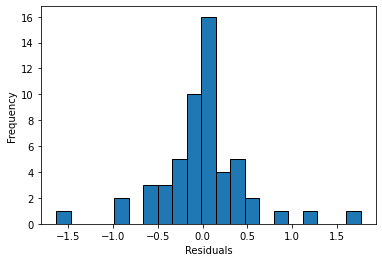

0.8978845477104187 0.00023986827000044286


In [21]:
# QQ-plot
import statsmodels.api as sm
# res.anova_std_residuals are standardized residuals obtained from two-way ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

# Shapiro-Wilk test
import scipy.stats as stats
w, pvalue = stats.shapiro(res.anova_model_out.resid)
print(w, pvalue)

- Even though we rejected the Shapiro-Wilk test statistics (p < 0.05), we should further look for the residual plots and histograms. 
- In the residual plot, standardized residuals lie around the 45-degree line, it suggests that the residuals are approximately normally distributed.
- Besides, the histogram shows the approximately normal distribution of residuals.

### Levene Test
We will use Levene’s test to check the assumption of homogeneity of variances

In [22]:
# if you have  a stacked table, you can use bioinfokit v1.0.3 or later for the Levene's test
from bioinfokit.analys import stat 
res = stat()
res.levene(df=d_melt, res_var='value', xfac_var=['Genotype', 'years'])
res.levene_summary

,Parameter,Value
0,Test statistics (W),1.6849
1,Degrees of freedom (Df),17.0000
2,p value,0.0927


As the p value (0.09) is non-significant, we fail to reject the null hypothesis and conclude that treatments have equal variances.

In [113]:
df = pd.read_csv('anova03.csv')
df.columns = ['cinsiyet', '25', '35', '45']
df['25'] = pd.to_numeric(df['25'], errors='coerce')
df['35'] = pd.to_numeric(df['35'], errors='coerce')
df['45'] = pd.to_numeric(df['45'], errors='coerce')
df['cinsiyet'] = 'Kadin'
df.cinsiyet[5:] = 'Erkek'
df

,cinsiyet,25,35,45
0,Kadin,18,16,16
1,Kadin,15,21,19
2,Kadin,19,22,20
3,Kadin,17,19,24
4,Kadin,18,24,21
5,Erkek,10,23,29
6,Erkek,11,22,26
7,Erkek,11,14,30
8,Erkek,16,17,27
9,Erkek,0,22,18


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   cinsiyet  10 non-null     object
 1   25        10 non-null     int64 
 2   35        10 non-null     int64 
 3   45        10 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 448.0+ bytes


In [129]:
df_melt = pd.melt(df.reset_index(), id_vars=['cinsiyet'], value_vars=['25', '35', '45'])
df_melt.columns = ['gender', 'age', 'value']
df_melt['age'] = pd.to_numeric(df_melt['age'], errors='coerce')
df_melt.head(2)

,gender,age,value
0,Kadin,25,18
1,Kadin,25,15


In [131]:
df_melt.replace(0, np.nan, inplace=True)
df_melt.isna().sum()

gender    0
age       0
value     1
dtype: int64

In [120]:
df_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gender  30 non-null     object
 1   age     30 non-null     int64 
 2   value   30 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 848.0+ bytes


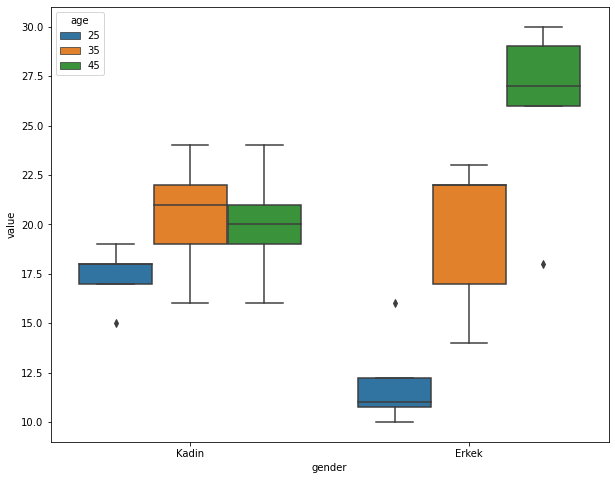

In [132]:
# generate a boxplot to see the data distribution by genotypes and years. Using boxplot, we can easily detect the 
# differences between different groups
plt.figure(figsize=(10,8))
sns.boxplot(x="gender", y="value", hue="age", data=df_melt) ;

In [136]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('value ~ C(age) + C(gender) + C(gender):C(age)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(age),305.928938,2.0,13.872961,0.000112
C(gender),0.138462,1.0,0.012558,0.911747
C(gender):C(age),156.261538,2.0,7.085992,0.004003
Residual,253.600000,23.0,NaN,NaN


In [138]:
dff = df_melt.loc[df_melt.age == 25]
model = ols('value ~ C(gender) ', data=dff).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(gender),64.8,1.0,14.538462,0.006603
Residual,31.2,7.0,NaN,NaN


In [139]:
dff = df_melt.loc[df_melt.age == 35]
model = ols('value ~ C(gender) ', data=dff).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(gender),1.6,1.0,0.130081,0.727686
Residual,98.4,8.0,NaN,NaN


In [140]:
dff = df_melt.loc[df_melt.age == 45]
model = ols('value ~ C(gender) ', data=dff).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(gender),90.0,1.0,5.806452,0.042531
Residual,124.0,8.0,NaN,NaN


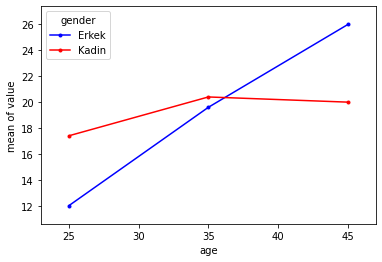

In [144]:
from statsmodels.graphics.factorplots import interaction_plot
fig = interaction_plot(x=df_melt['age'], trace=df_melt['gender'], response=df_melt['value'], 
    colors=['b','r'])
plt.show()

# Pearson Correlation Sample

In [146]:
df = pd.DataFrame({'age' :[45,40,20,18,50,25,42,30,45,43,42,30,45],
                  'value' : [25,24,16,19,28,17,30,21,30,27,26,25,26]})
df

,age,value
0,45,25
1,40,24
2,20,16
3,18,19
4,50,28
5,25,17
6,42,30
7,30,21
8,45,30
9,43,27


- Pearson tercih edilir cunku ikiside oranli numeric degisken (numeric ama orani alinan bir deger benim yasim seninkin 2 kati mantiklidir.)

In [150]:
df.corr(method='pearson')

,age,value
age,1.0000,0.8763
value,0.8763,1.0000


In [154]:
# Seydahmet Ercan Hoca var = df.corr()^2 karesi olarak aliyor 0.873^2= 0.77 oluyor
df.var()

age      112.102564
value     21.141026
dtype: float64

In [155]:
df.describe()

,age,value
count,13.000000,13.000000
mean,36.538462,24.153846
std,10.587850,4.597937
min,18.000000,16.000000
25%,30.000000,21.000000
50%,42.000000,25.000000
75%,45.000000,27.000000
max,50.000000,30.000000


<AxesSubplot:xlabel='age', ylabel='value'>

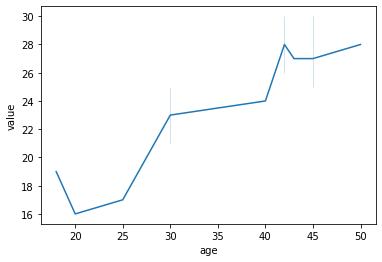

In [168]:
sns.lineplot(data=df, x='age', y='value')

# Spearman Rho Corr

In [170]:
df = pd.DataFrame({'age' :[1,2,3,4,5,6,7,8,9,10,11,12,13],
                  'value' : [25,16,16,19,28,17,30,21,30,27,26,33,26]})
df

,age,value
0,1,25
1,2,16
2,3,16
3,4,19
4,5,28
5,6,17
6,7,30
7,8,21
8,9,30
9,10,27


- Spearman tercih edilir cunku biris SIRALI degisken, digeri Oranli Degisken
- Age sirali sekilde ifade edilmis 1,2,3 (ordinal)
- Value ise numeric

In [171]:
df.corr(method='spearman')

,age,value
age,1.00000,0.60966
value,0.60966,1.00000


In [182]:
df = pd.read_csv('anova03.csv')
df.columns = ['cinsiyet', '25', '35', '45']
df['25'] = pd.to_numeric(df['25'], errors='coerce')
df['35'] = pd.to_numeric(df['35'], errors='coerce')
df['45'] = pd.to_numeric(df['45'], errors='coerce')
df['cinsiyet'] = 'Kadin'
df.cinsiyet[5:] = 'Erkek'
df = pd.melt(df.reset_index(), id_vars=['cinsiyet'], value_vars=['25', '35', '45'])
df.head()

,cinsiyet,variable,value
0,Kadin,25,18
1,Kadin,25,15
2,Kadin,25,19
3,Kadin,25,17
4,Kadin,25,18
